In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import os 

In [2]:
import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
store_gamma = pd.HDFStore("output_PU_clusters_check_gamma_v7.h5")
df_gamma = store_gamma['df']
store_gamma.close()

In [4]:
store_ele = pd.HDFStore("output_PU_clusters_check_electron_v7.h5")
df_ele = store_ele['df']
store_ele.close()

In [6]:
print("N events ele", len(df_ele))
print("N events gamm``a", len(df_gamma))

N events ele 2851053
N events gamm``a 2256072


# Resolution study

In [20]:
df = df_gamma

In [21]:
#base line selection
# - Pass simfraction seed and clusters
# - geometric window of the seed
# - PU cut

In [22]:
seed = df[(df.is_seed==1)][['wi','en','eta','et', 'simfrac_sig']]
seed.columns = ['wi','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("wi"), on='wi')

dfb = dfa[(dfa.seed_simfrac_sig > 0.01) & (dfa.in_window) & (dfa.pass_simfrac_thr ==1 ) & (dfa.PUsimen_frac < 1)]
dfb["noise_frac"] = dfb.noise_en / dfb.en

<ipython-input-22-5d17716d7557>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["noise_frac"] = dfb.noise_en / dfb.en


Text(1, 0, 'Noise En / raw En')

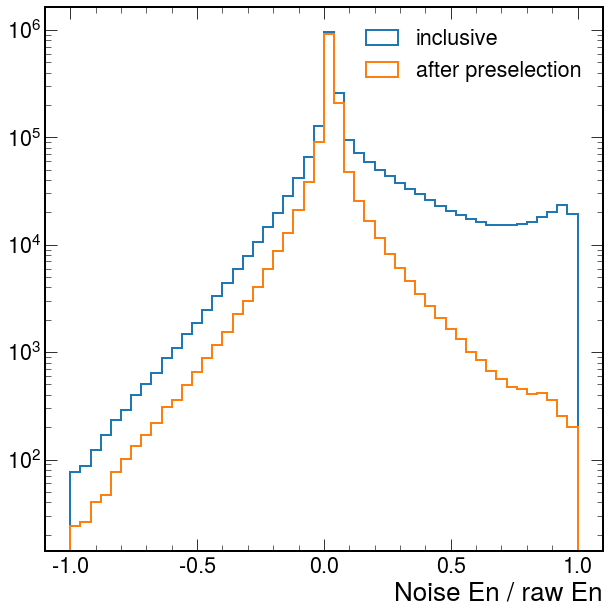

In [23]:
plt.hist(dfa.noise_en / dfa.en, bins=50, range=(-1,1), histtype="step", label="inclusive", linewidth=2)
plt.hist(dfb.noise_en / dfb.en, bins=50, range=(-1,1), histtype="step", label="after preselection", linewidth=2)
plt.legend()
plt.yscale("log")
plt.xlabel("Noise En / raw En")

Text(1, 0, 'Noise En / raw En')

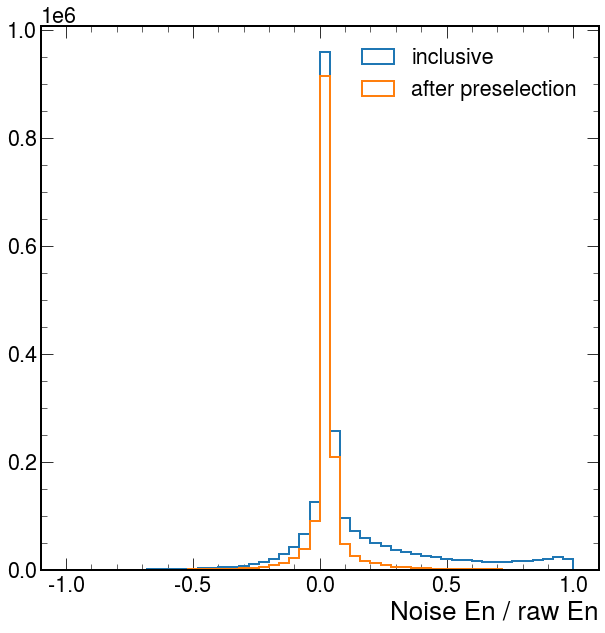

In [24]:
plt.hist(dfa.noise_en / dfa.en, bins=50, range=(-1,1), histtype="step", label="inclusive", linewidth=2)
plt.hist(dfb.noise_en / dfb.en, bins=50, range=(-1,1), histtype="step", label="after preselection", linewidth=2)
plt.legend()
# plt.yscale("log")
plt.xlabel("Noise En / raw En")

In [25]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [33]:
etas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.35, 1.44, 1.57, 1.75, 2.0 ,2.2,2.4,3.0]
ets =   [ 0,2,3,4,6,10,15,20,30,40,50,60,70,80,90,100]
thres = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,0.4,0.45, 0.5,0.55, 0.6,0.65,0.7,0.75,0.8,0.9,1]
    
res= []
# res_all = []

for thr in thres:
    #print("DNN threshold: ", thr)
    g = dfb[(abs(dfb.noise_frac) < thr ) | (dfb.is_seed==1) ].groupby("wi", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_genen": "first", 
                         "calo_simen_good": "first", 
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen_good"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"], etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)                   
    scanres["thr"] = thr
    res.append(scanres)

res = pd.concat(res)

In [34]:
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

In [35]:
import os
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/noise_fraction_gamma/abs"
os.makedirs(outputdir, exist_ok=True)

# Plots

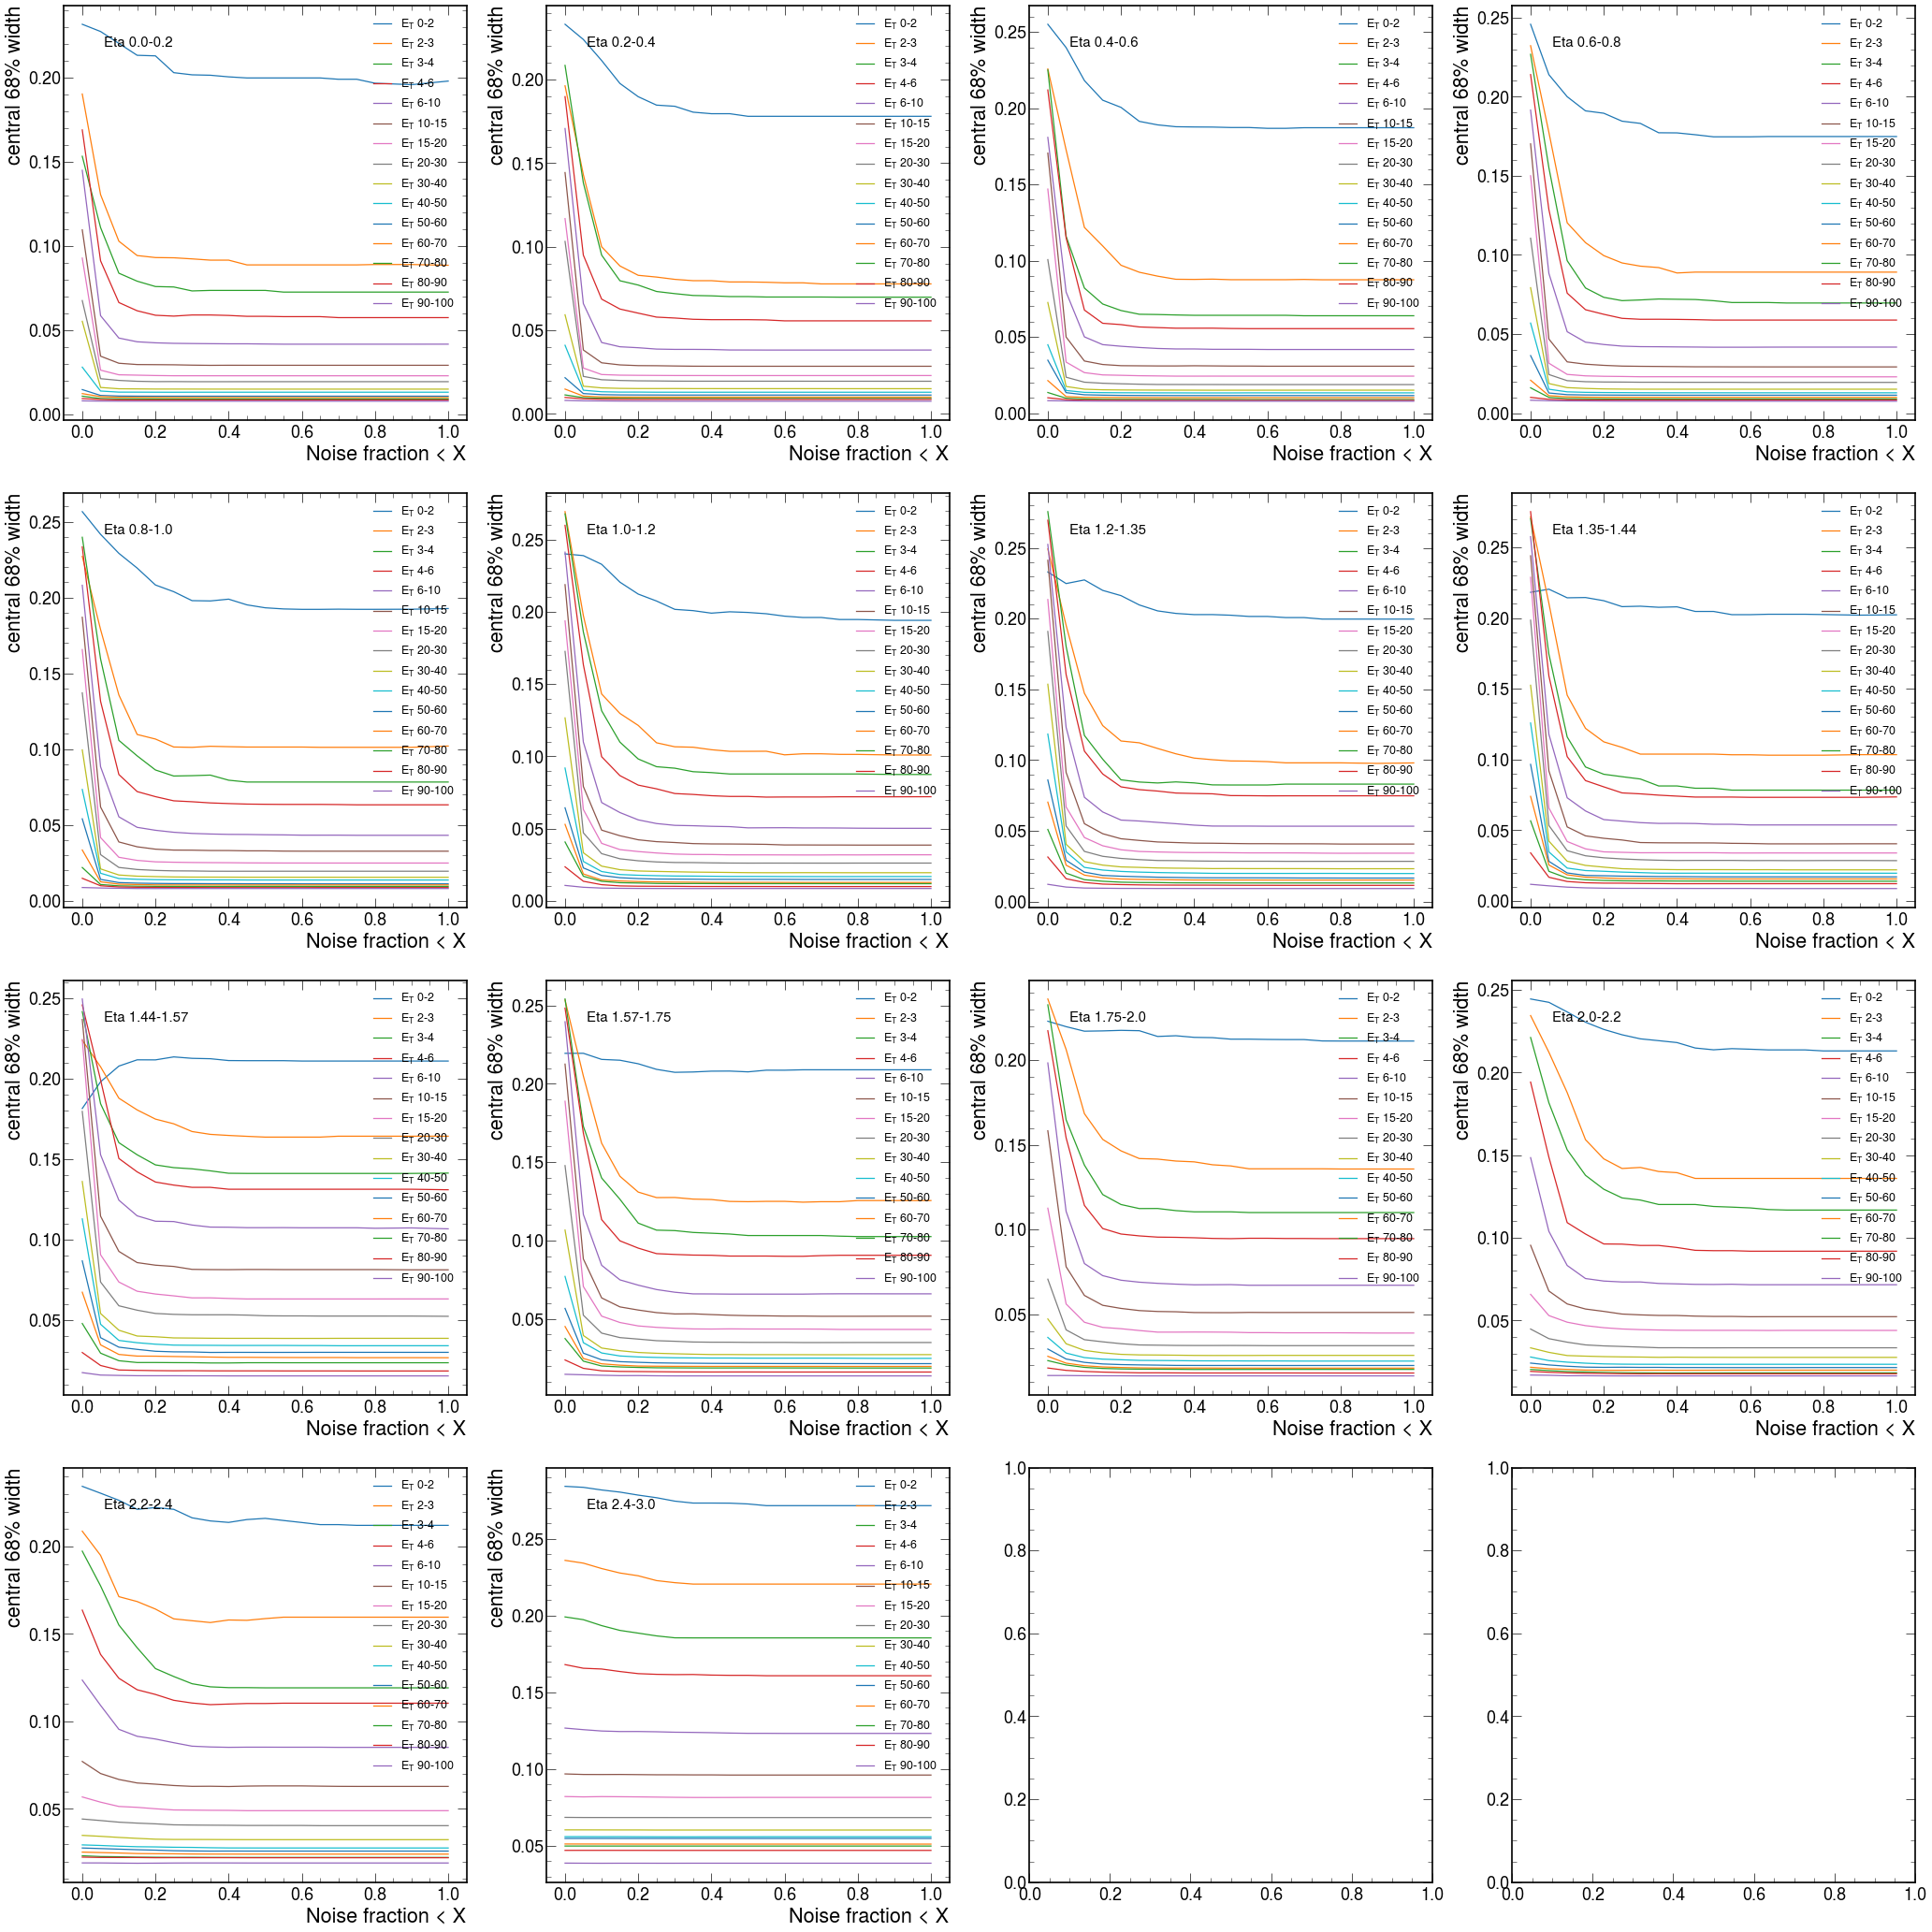

In [36]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper right')
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("Noise fraction < X")
#     ax.set_xlim(0.01, 1000)
#     ax.set_xscale("log")
f.tight_layout()
f.savefig(outputdir + '/width_ele.png')
    

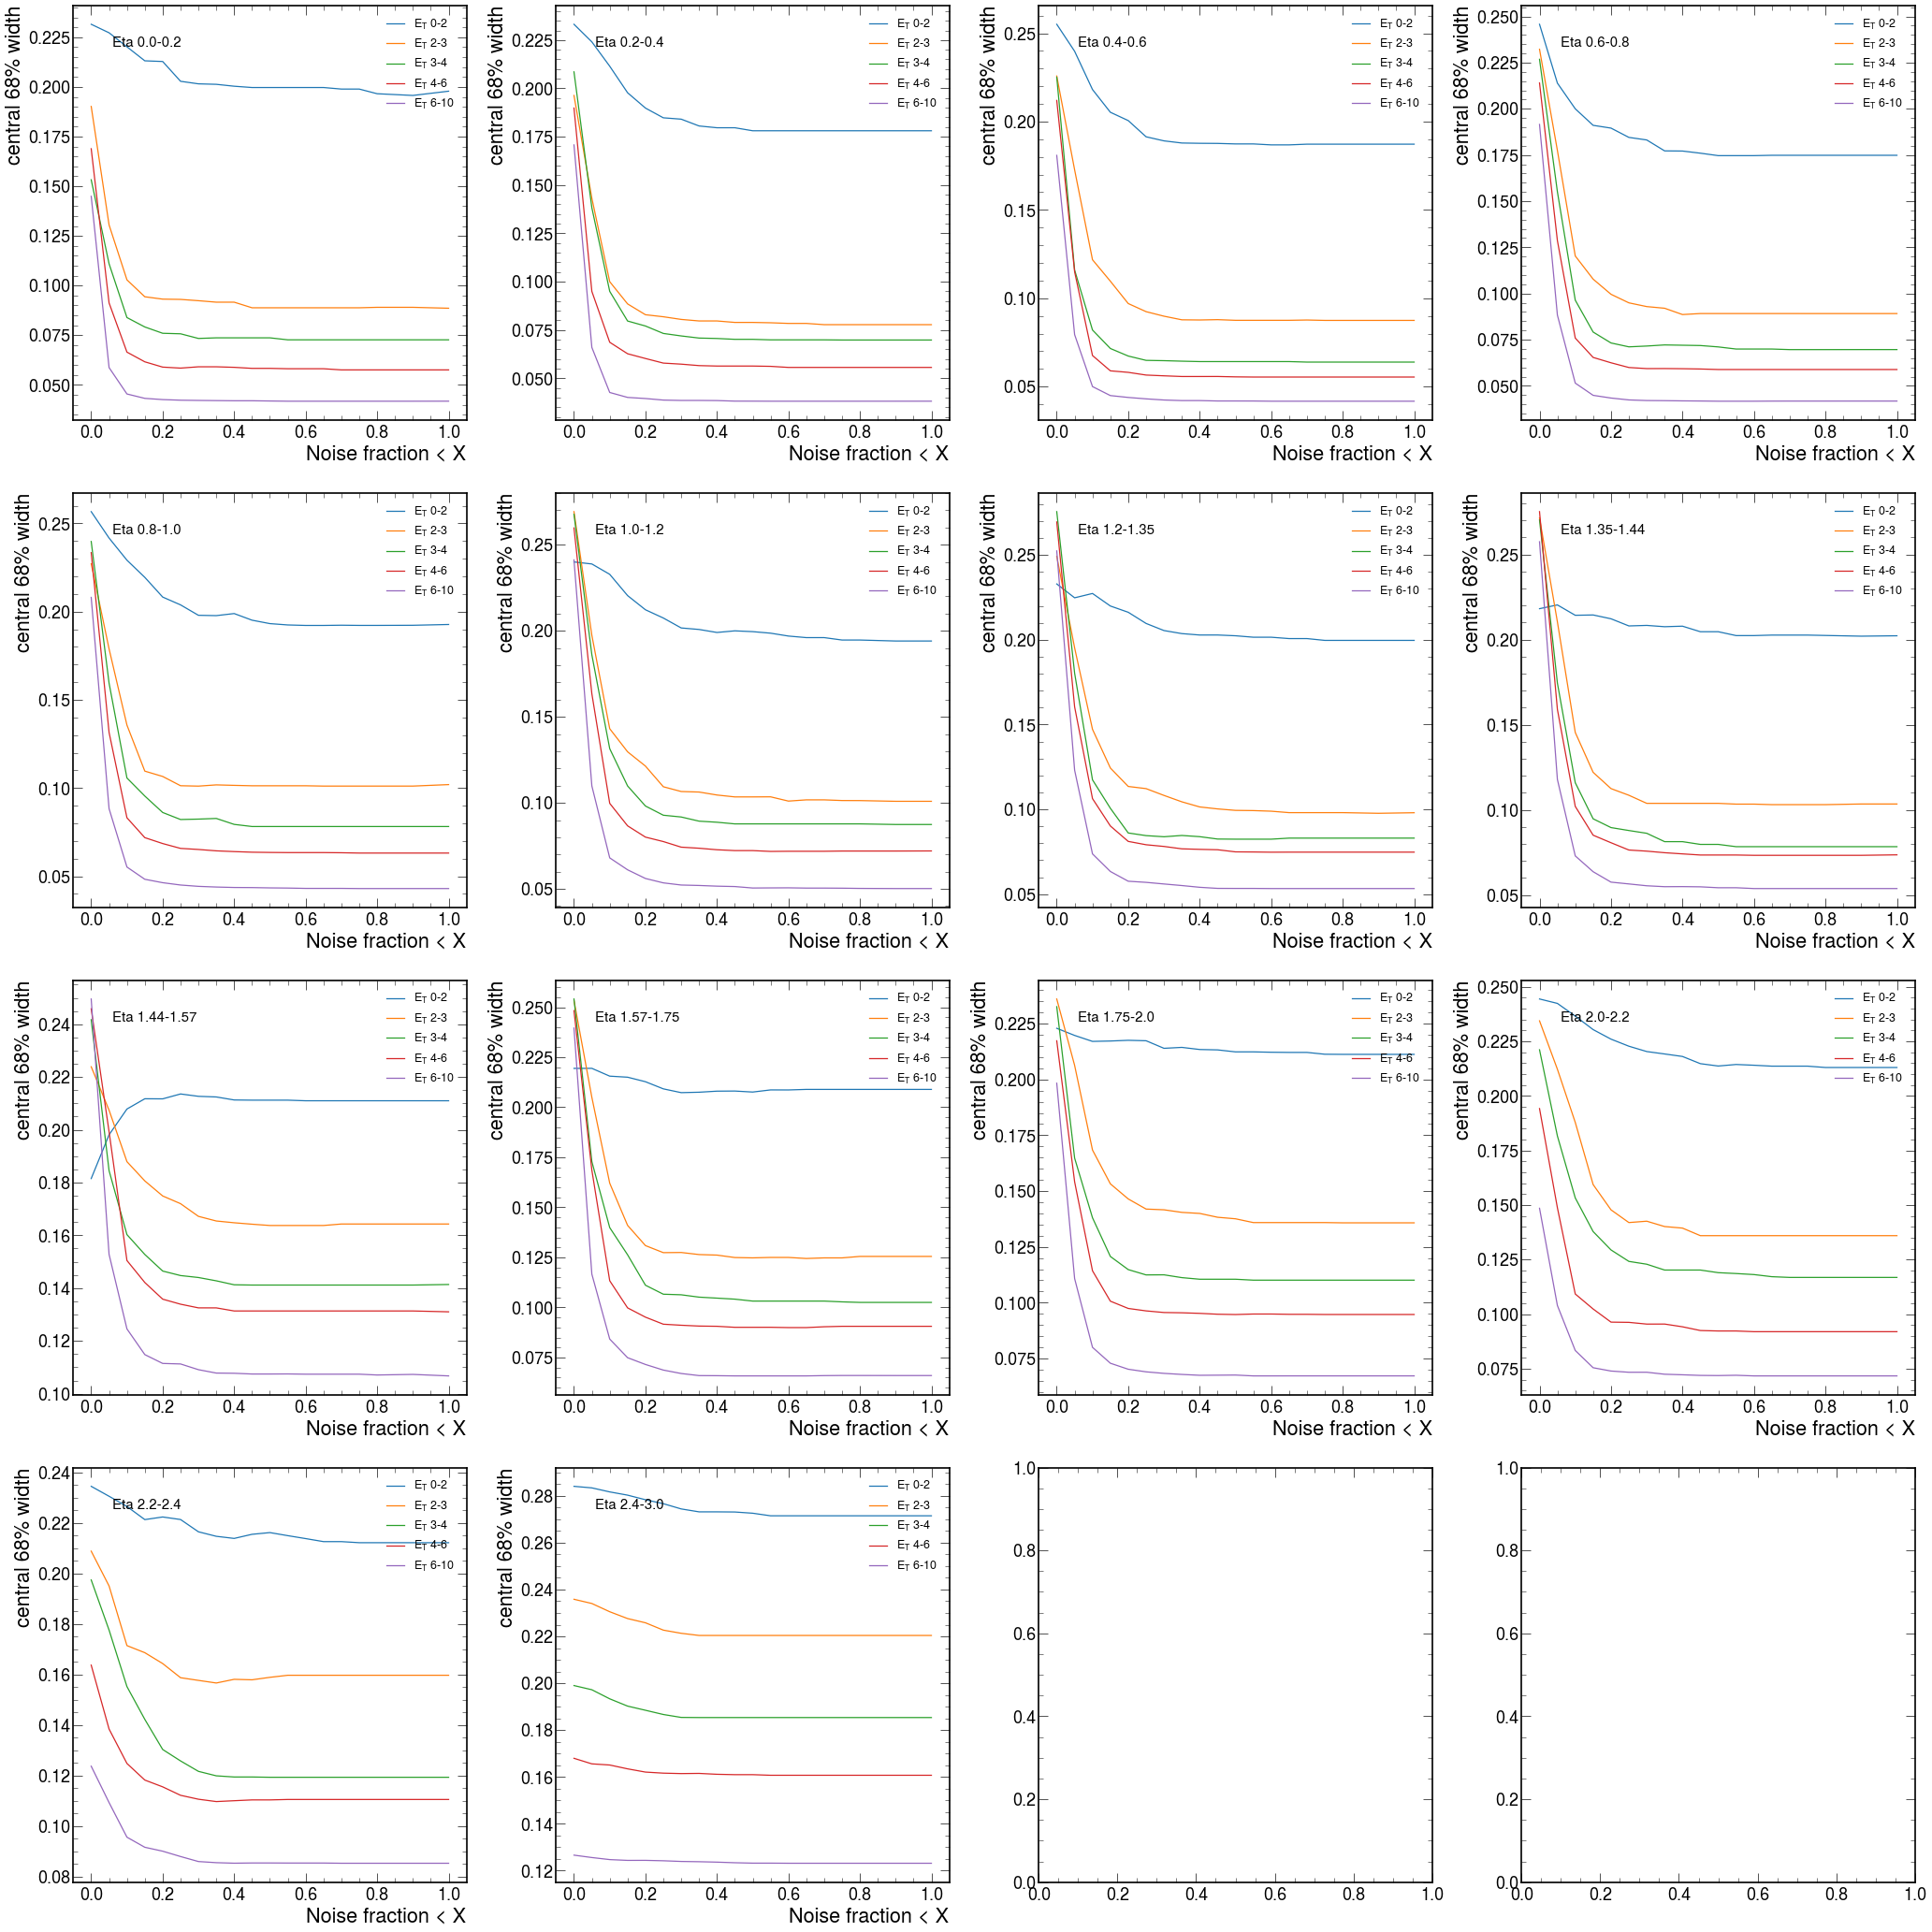

In [37]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(5):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper right')
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("Noise fraction < X")
#     ax.set_xlim(0.01, 1000)
#     ax.set_xscale("log")
f.tight_layout()
f.savefig(outputdir + '/width_lowEt_ele.png')
    

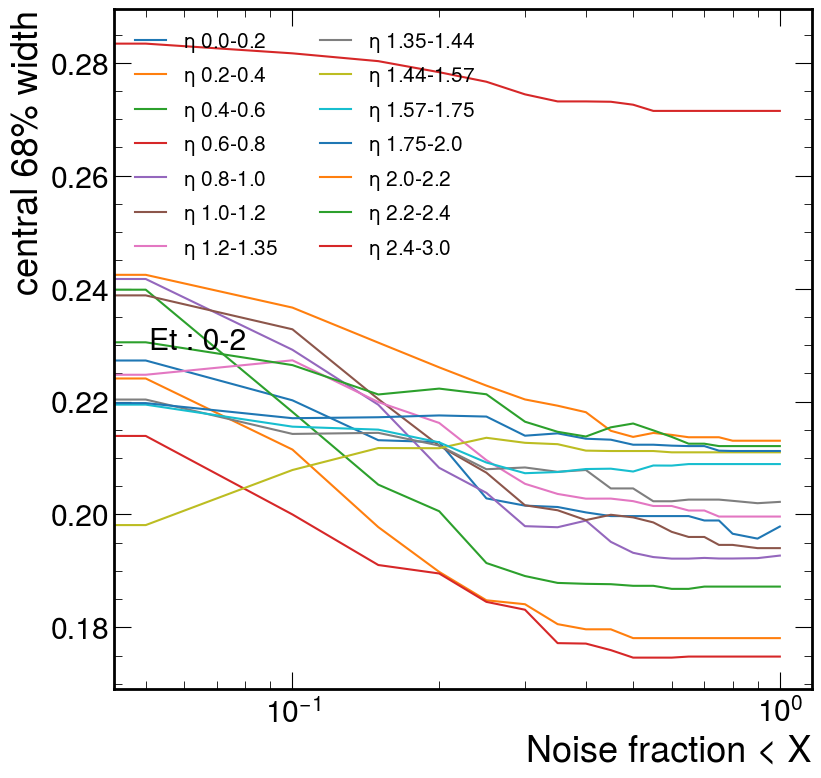

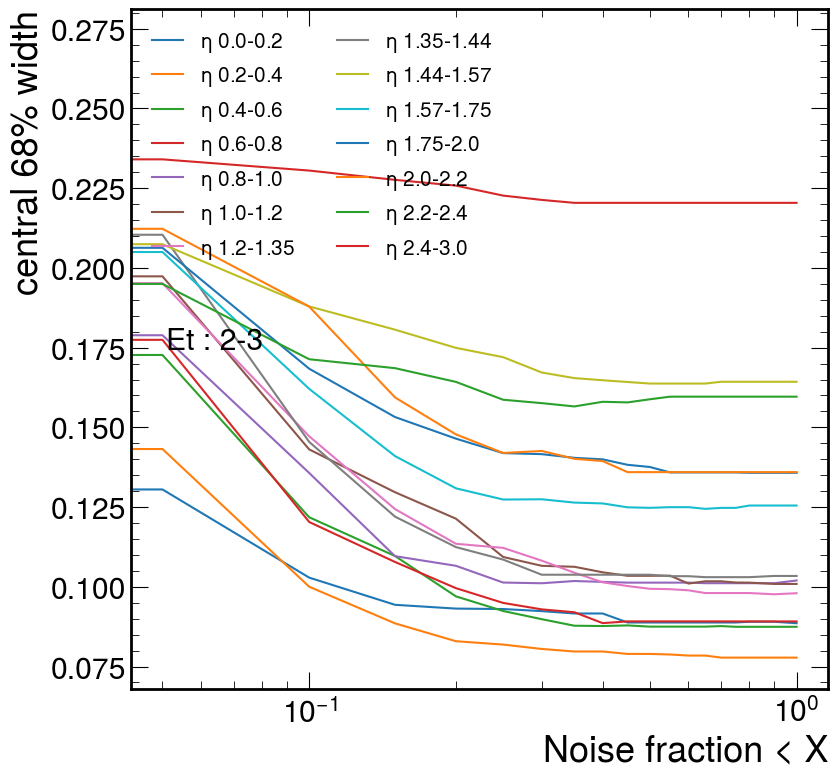

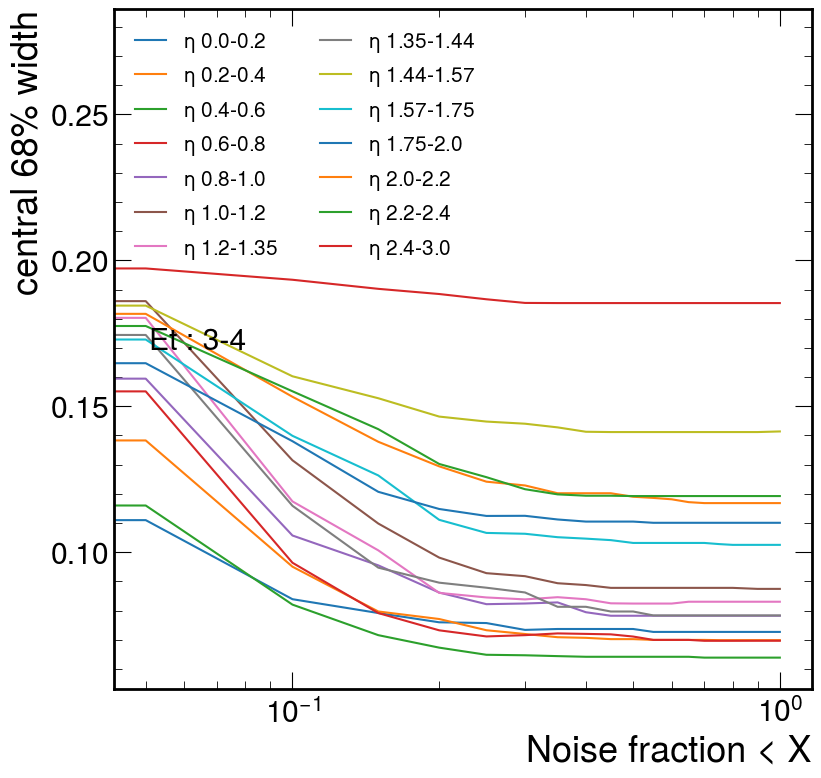

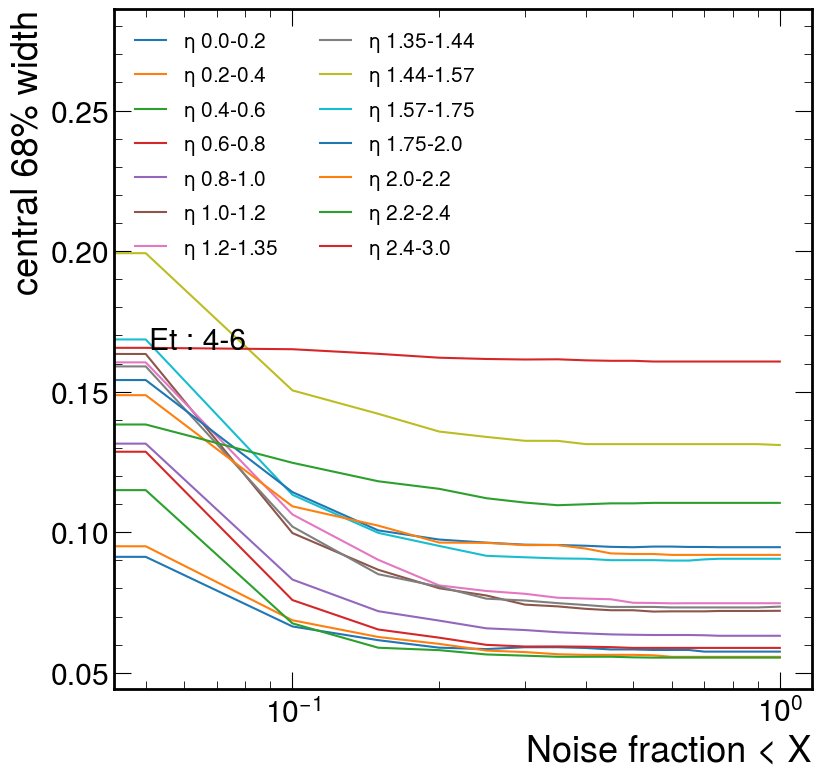

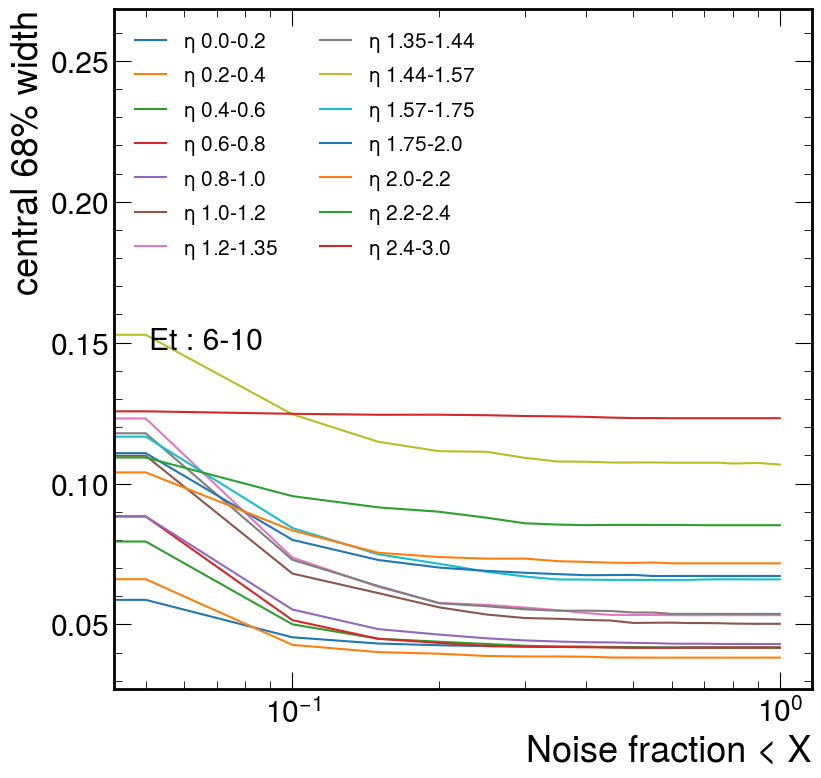

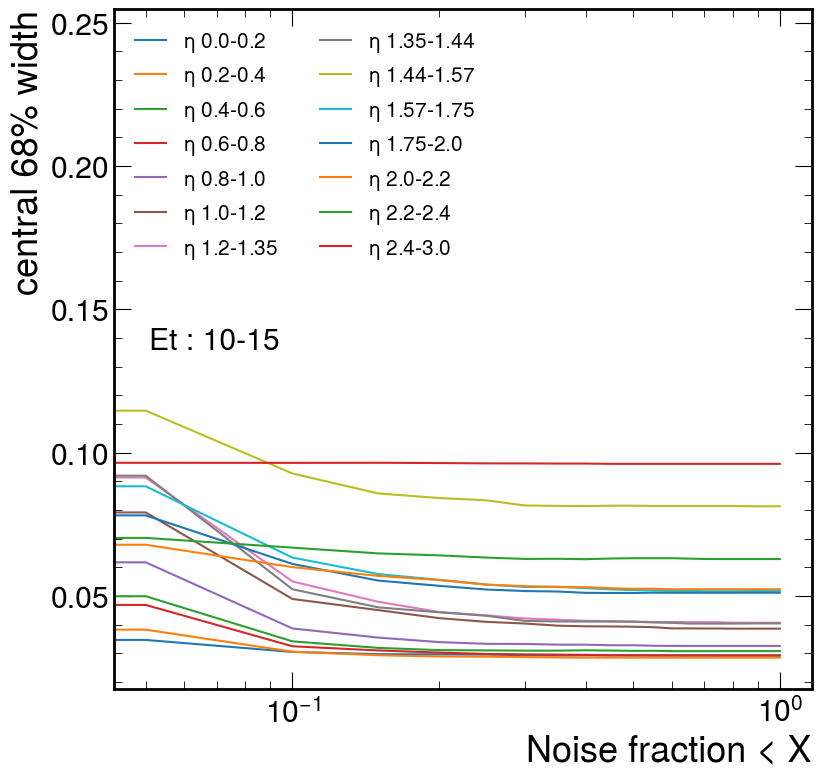

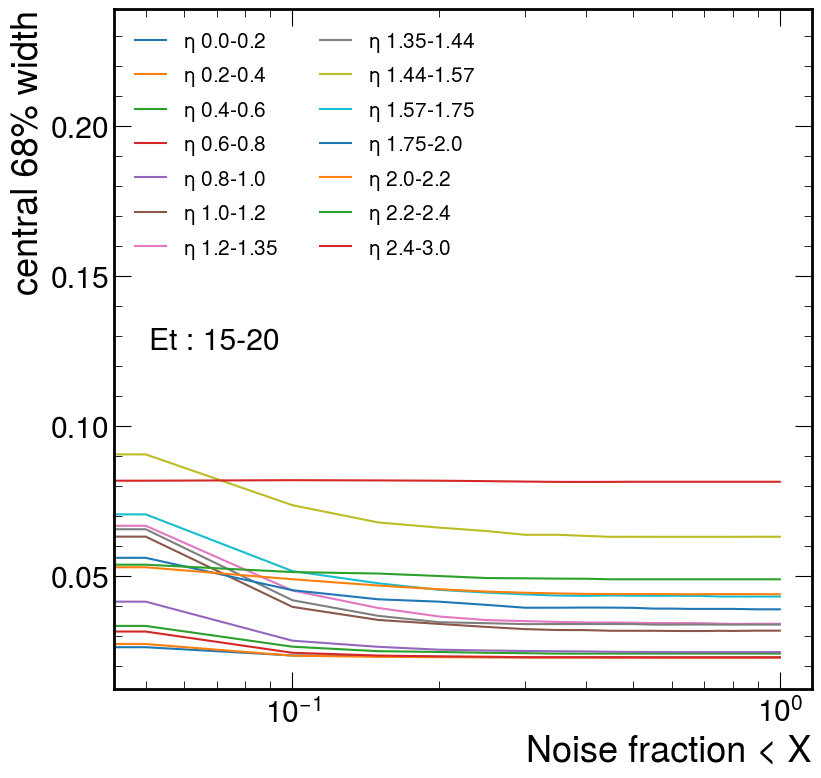

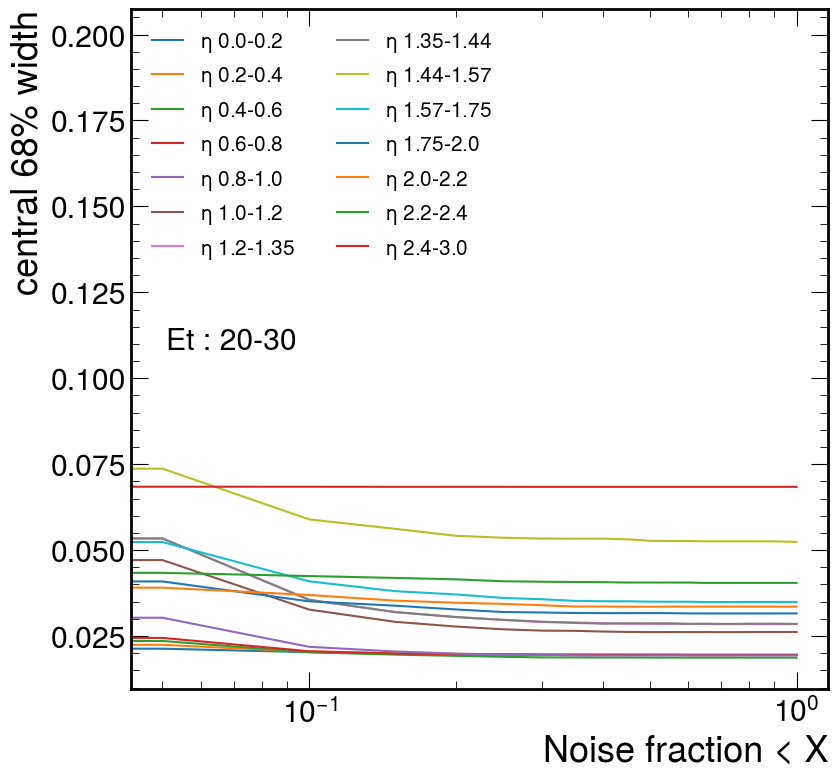

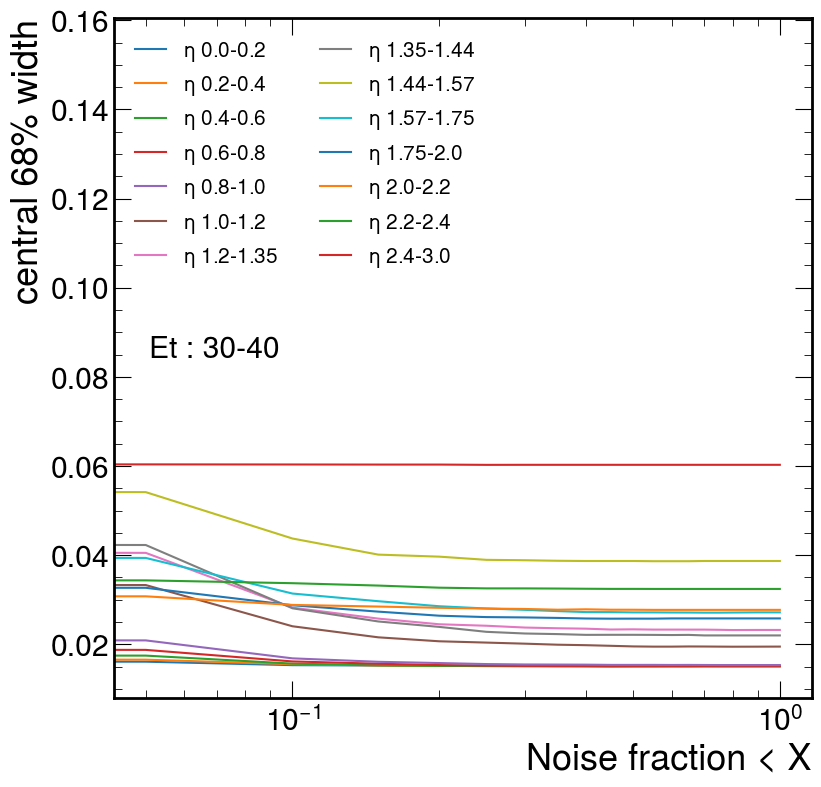

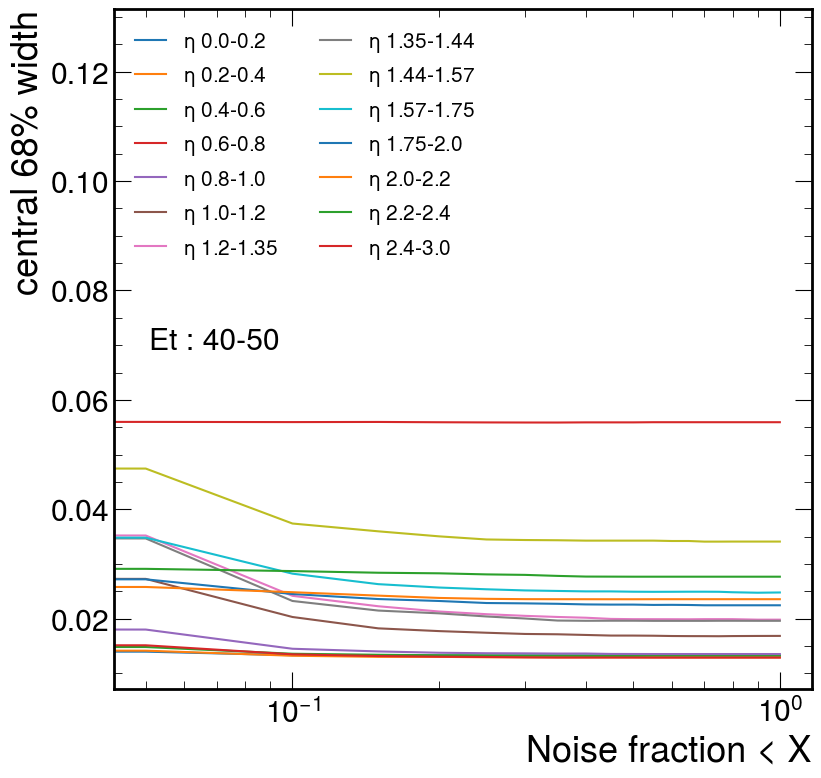

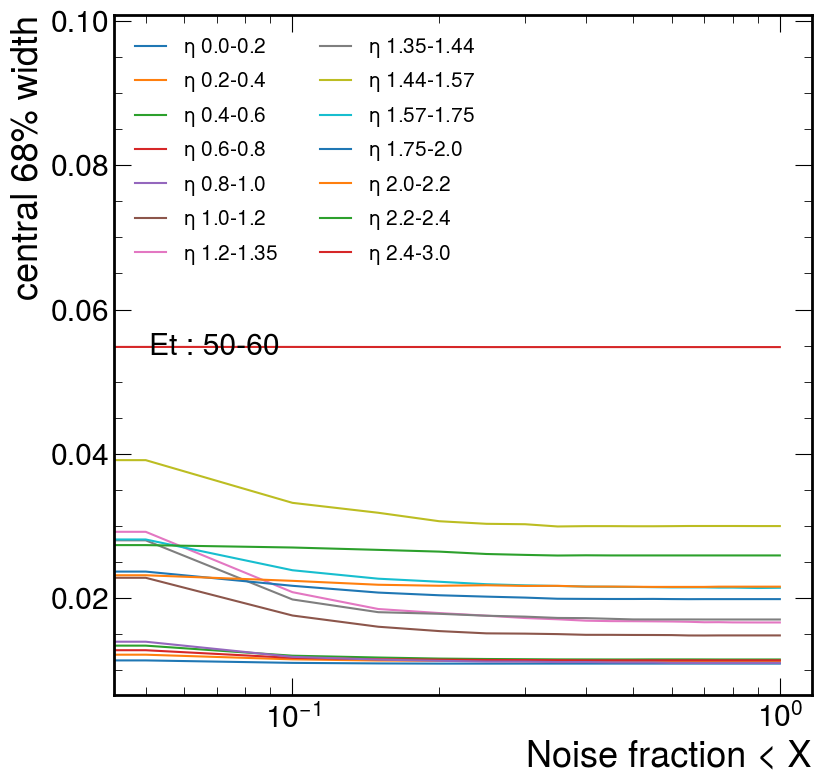

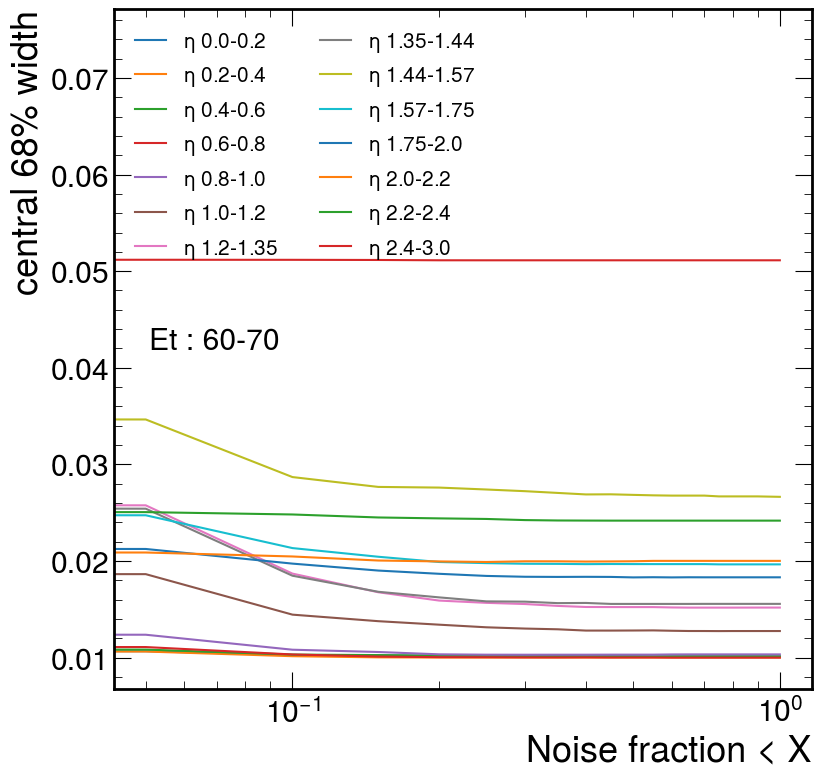

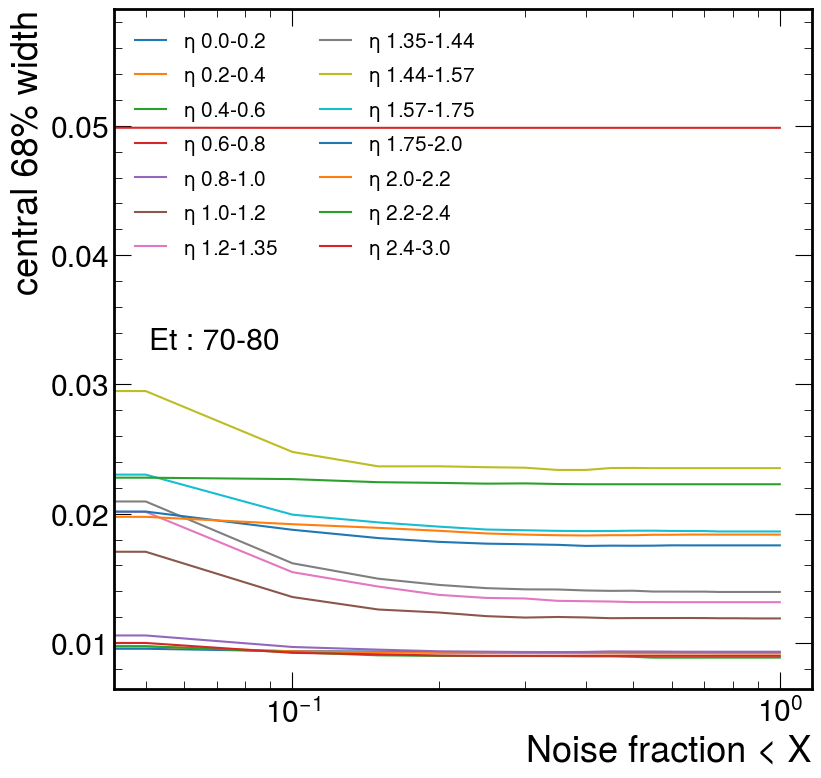

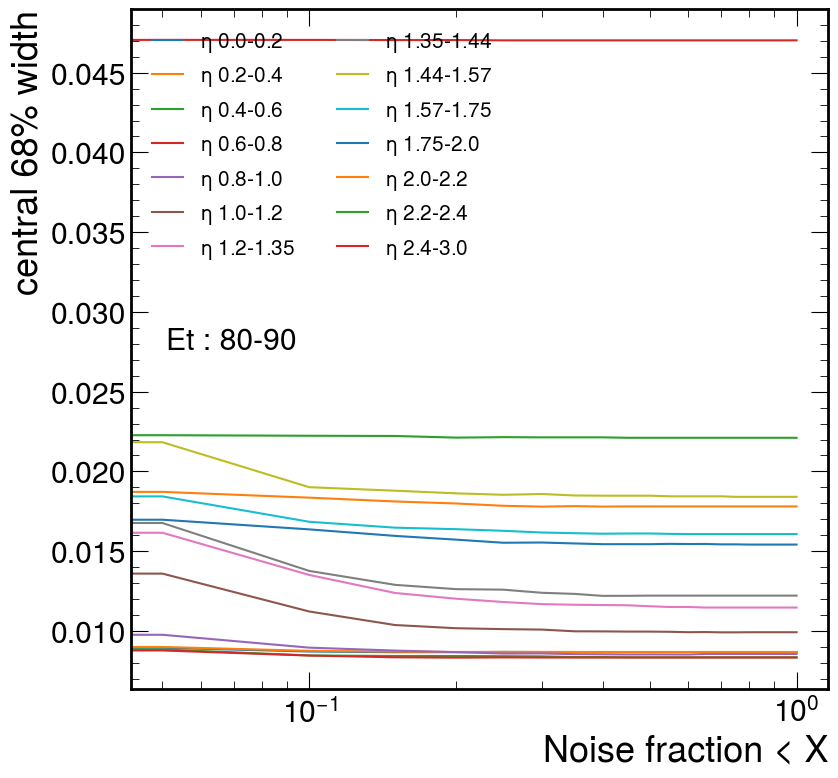

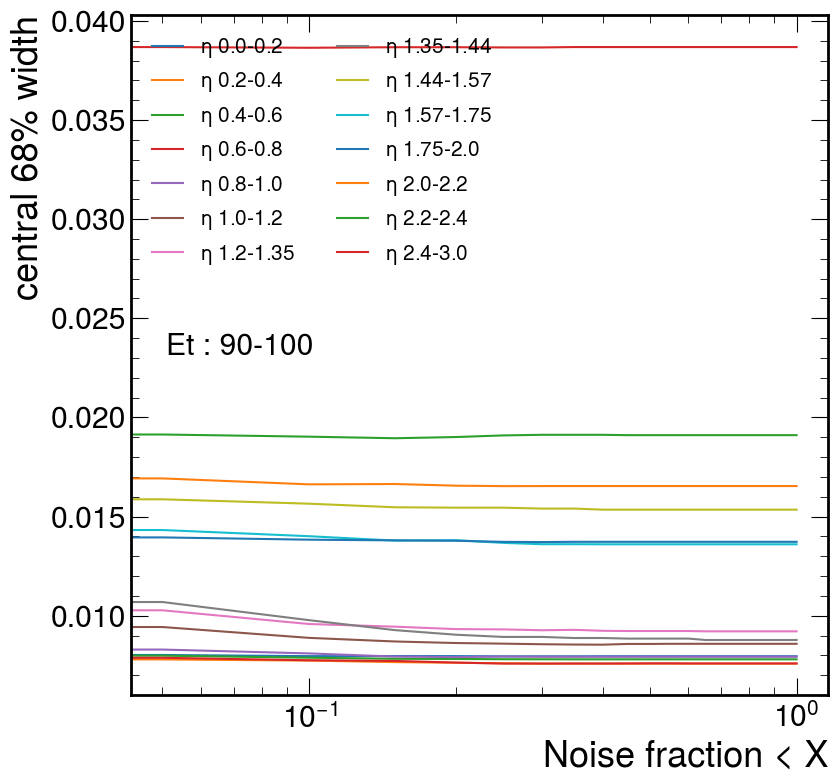

In [38]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("Noise fraction < X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_Et{}_{}.png'.format(ets[iet],ets[iet+1]))

# Scale

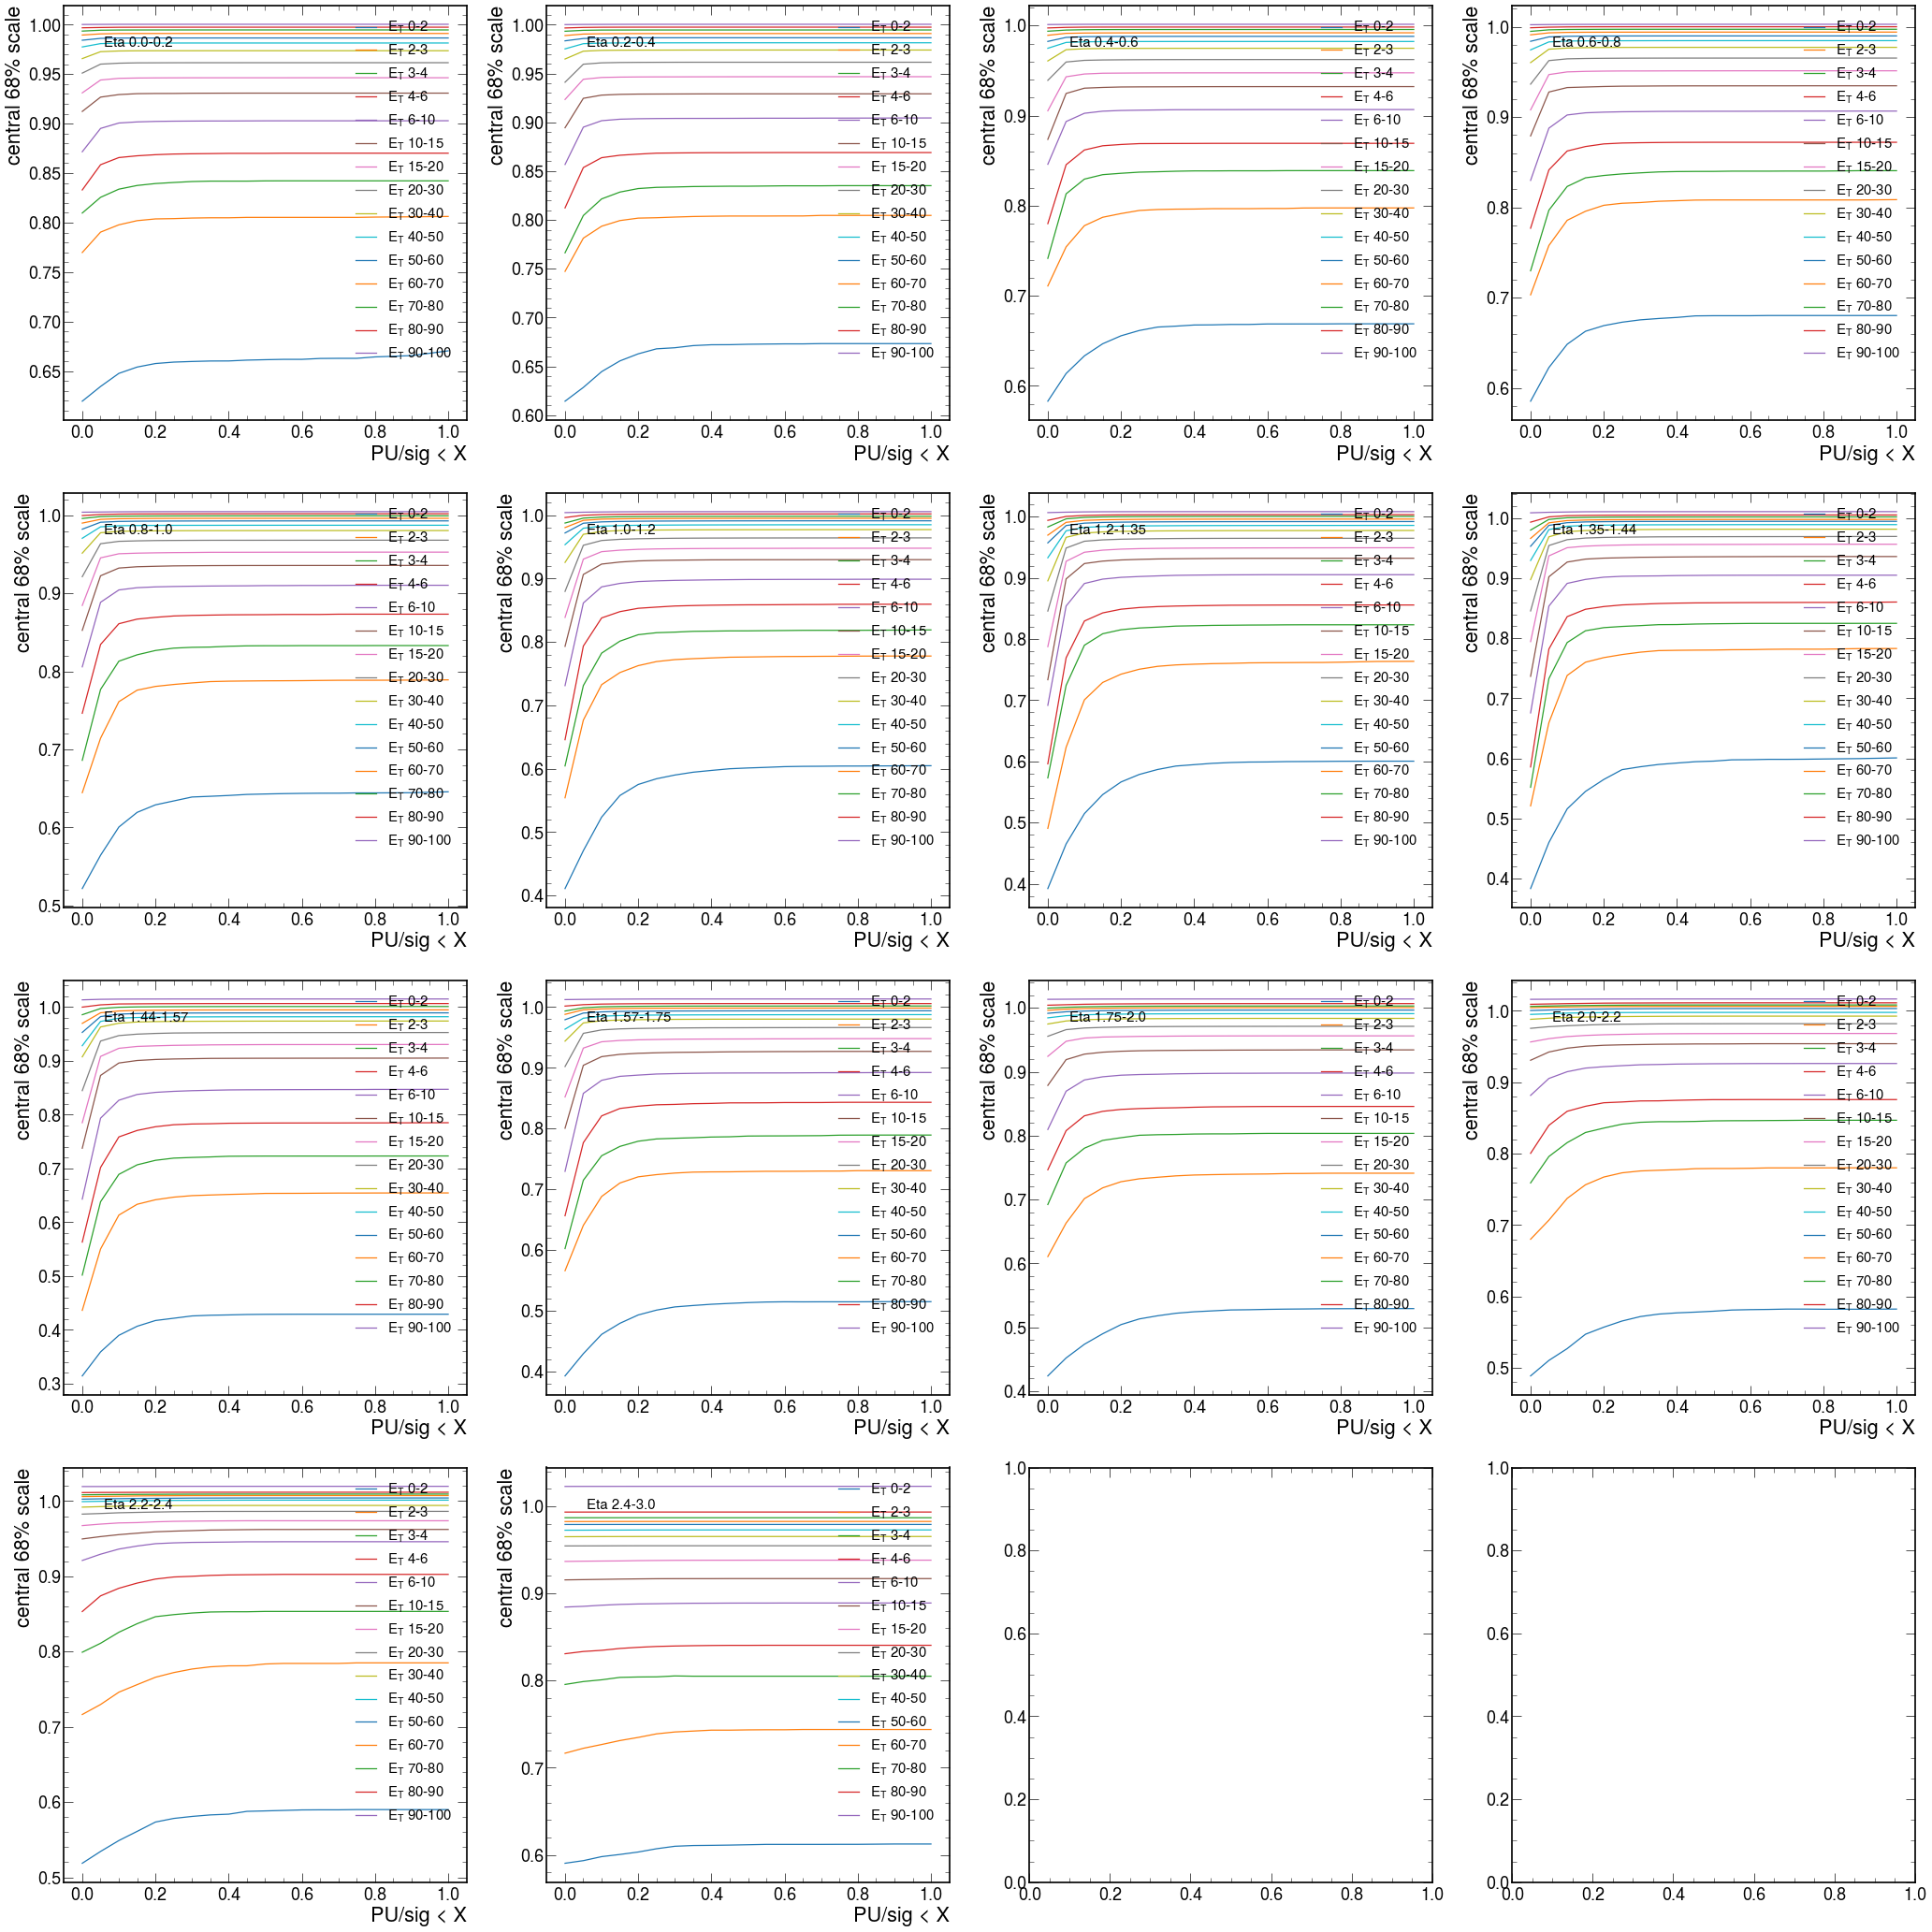

In [39]:
f, axs = plt.subplots(4,4, figsize=(35,35), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(0,len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="x-small", loc='upper right')
    ax.set_ylabel("central 68% scale")
    ax.set_xlabel("PU/sig < X")
#     ax.set_xlim(0.01, 1000)
#     ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir + '/scale_ele.png')
# f.savefig(outputdir + "/scal_by_PU_thre.png")
    